In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
import jax
#from jax import numpy as jnp
import optax
from scipy.integrate import trapezoid  # For numerical integration

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Gaussian Distribution

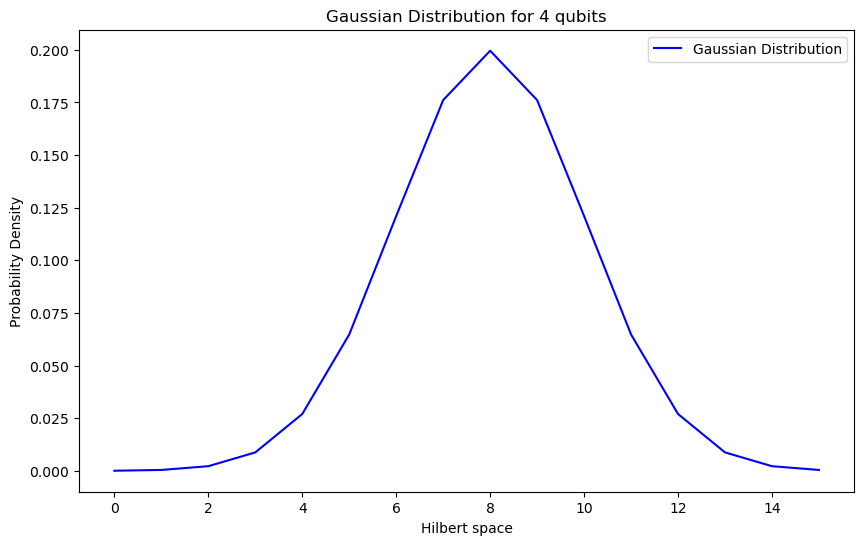

In [21]:
n_qubits = 4
# x values for 6 qubits range from 0 to 16
x = np.arange(0, 2**n_qubits)

# Parameters for the Gaussian distribution
mu = 2**(n_qubits-1)  # mean
sigma = 2**(n_qubits-1)/4  # standard deviation

# Gaussian distribution formula
gaussian_distribution = (1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2))

area = trapezoid(gaussian_distribution,x)
gaussian_distribution /= area

# Plot the Gaussian distribution
plt.figure(figsize=(10, 6))
plt.plot(x, gaussian_distribution, label='Gaussian Distribution', color='blue')
plt.title(f'Gaussian Distribution for {n_qubits} qubits')
plt.xlabel('Hilbert space')
plt.ylabel('Probability Density')
# plt.gca().set_yticklabels([])
# plt.grid(True)
plt.legend()
plt.show()

In [4]:
def pnumber_distribution(distribution):
    p_distribution = np.zeros(n_qubits+1)
    
    for i in range(2**n_qubits):
        binary_string = format(i,'06b')
        num_of_ones = binary_string.count('1')
        p_distribution[num_of_ones] += distribution[i]
        
    #Normalize the distribution
    p_distribution/=p_distribution.sum()
    return p_distribution

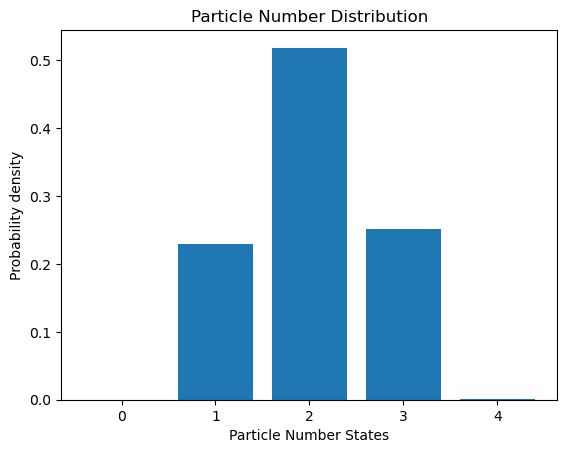

In [22]:
targetp_distribution = pnumber_distribution(gaussian_distribution)
plt.bar(range(n_qubits+1), targetp_distribution)
plt.title('Particle Number Distribution')
plt.ylabel('Probability density')
plt.xlabel('Particle Number States')
plt.xticks(range(n_qubits+1))
# plt.gca().set_yticklabels([])
# plt.grid(True)
plt.show()

In [6]:
all_states = []
for i in range(2**4):
    binary_string = format(i,'04b')
    all_states.append(binary_string)
all_states

['0000',
 '0001',
 '0010',
 '0011',
 '0100',
 '0101',
 '0110',
 '0111',
 '1000',
 '1001',
 '1010',
 '1011',
 '1100',
 '1101',
 '1110',
 '1111']

In [24]:
all_states[15].count('1')

4

#### QCBM Circuit

In [7]:
dev = qml.device('default.qubit',wires=n_qubits)

def random_init(num_qubits):
    all_states = []
    for i in range(2**num_qubits):
        binary_string = format(i,'04b')
        all_states.append(binary_string)
        
    #random_states = np.random.choice(all_states,4)
    #states = ['0000','0001','0011','0111','1111']
    amps = [6.6920766e-05,2.2913826e-01, 0, 5.1856565e-01, 0,0,0, 2.5179282e-01, 0,0,0,0,0,0,0,4.3637821e-04]
    amps = np.sqrt(amps)
    # for i in range(len(all_states)):
    #     if all_states[i] in states:
    #         amps.append(np.sqrt(targetp_distribution[i]))
    #     else:
    #         amps.append(0)
    norm = np.sqrt(sum(np.abs(amp)**2 for amp in amps))
    amps = amps/norm
    # print(random_states)
    #print(amps)
    qml.StatePrep(amps,wires=range(num_qubits))
    
def qcbm_circuit(params,num_qubits):
    
    rz_params = params[:num_qubits]
    ising_params = params[num_qubits:]
    for i in range(num_qubits):
        qml.RZ(rz_params[i],wires=i)
        # qml.RY(params[i],wires=i)
    qml.IsingXY(ising_params[0],wires=[0,1])
    qml.IsingXY(ising_params[2],wires=[1,2])
    qml.IsingXY(ising_params[1],wires=[2,3])
    qml.IsingXY(ising_params[3],wires=[0,3])


@qml.qnode(dev)
def circuit(input_params,num_qubits=n_qubits):
    
    #Random state for pretraining
    random_init(num_qubits)
    for i in range(3):
        qml.Barrier(range(num_qubits))
        qcbm_circuit(params=input_params[i],num_qubits=num_qubits)
    return qml.probs()


In [ ]:
#Initialization for qcbm circuit

a=np.random.choice(['0001','0010','0100','1000'],1)[0]
b=np.random.choice(['0011','0101','1001','0110','1100','1010'])[0]
c=np.random.choice(['0111','1011','1101','1110'])[0]

states = ['0000',a,b,c,'1111']
amps = [6.6920766e-05,2.2913826e-01, 0, 5.1856565e-01, 0,0,0, 2.5179282e-01, 0,0,0,0,0,0,0,4.3637821e-04]
amps = np.sqrt(amps)
    # for i in range(len(all_states)):
    #     if all_states[i] in states:
    #         amps.append(np.sqrt(targetp_distribution[i]))
    #     else:
    #         amps.append(0)
norm = np.sqrt(sum(np.abs(amp)**2 for amp in amps))
amps = amps/norm
amps

In [ ]:
#superposition of all states
#fully entangling layers (RX/RY and RZ,CNOT) -- find min number of params to obtain kl div=10^-3
#same with pre-training + no pre-training
#IsingZZ + RZ

## Training

In [10]:
#Defining squared maximum mean discrepancy (MMD) Loss function for Radial basis function (RBF) kernel
class MMD:
    
    def __init__(self, scales, space):
        #scales = list of guassian width (sigma)
        #space = data points x and y
        
        gammas = 1 / (2*(scales**2)).reshape(-1, 1, 1)  # Reshape gammas to (2, 1, 1)
        sq_dists = np.abs(space[:,None] - space[None,:])**2
        self.K = np.sum(np.exp(-gammas * sq_dists), axis=0) / len(scales)
        self.scales = scales
        
    def k_expval(self,px,py):
        #print(np.shape(self.K))
        return px @ self.K @ py
    
    def __call__(self,px,py):
        pxy = px-py
        #print(self.K)
        return self.k_expval(pxy,pxy)

In [11]:
from functools import partial

class QCBM:
    
    def __init__(self,circ,mmd,py):
        self.circ = circ    #qcbm circuit
        self.mmd = mmd      #MMD call
        self.py = py        #target distribution pi(x)
        
    #@partial(jax.jit, static_argnums=0)
    def mmd_loss(self,params):
        px = self.circ(params)  #Obtained probability distribution
        return self.mmd(px,self.py), px

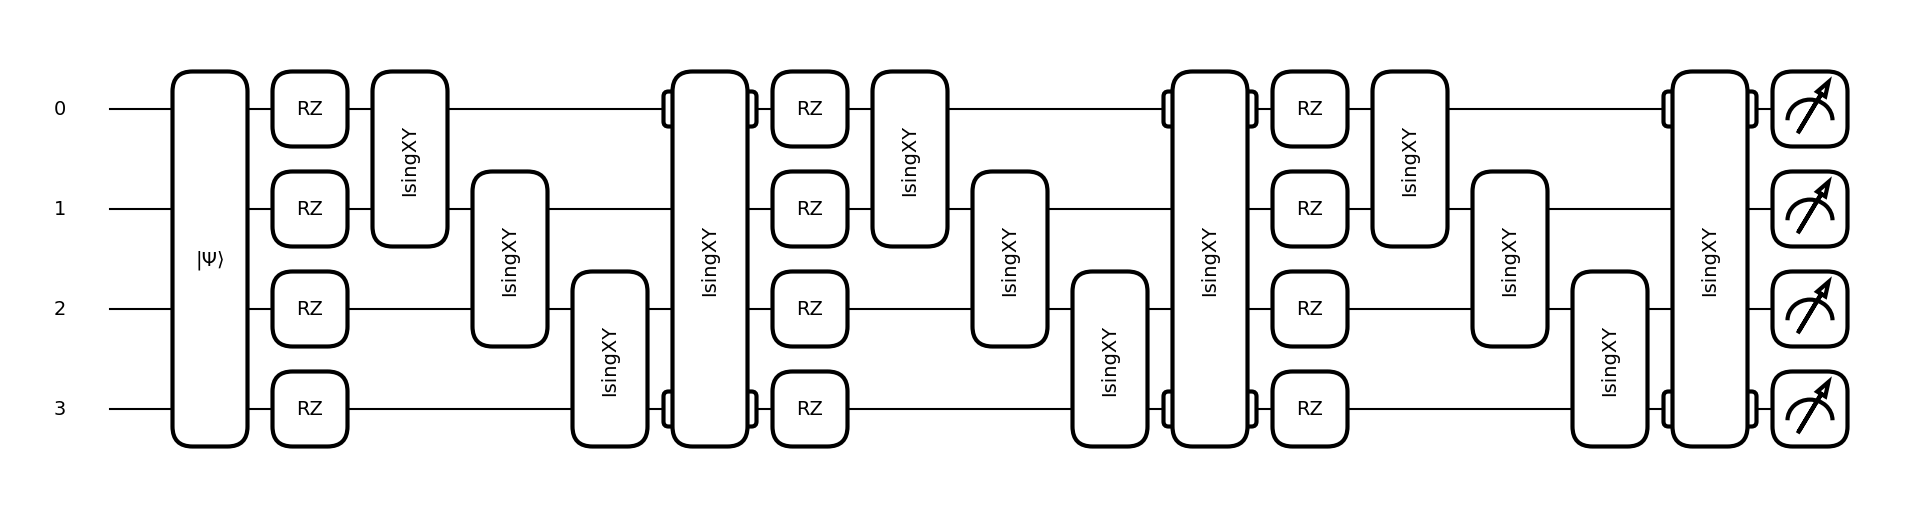

In [12]:
#jit_circuit = jax.jit(circuit)
    
# Example parameters: [RZ params, IsingXY params]
folds = 3
initial_params = []
for i in range(folds):
    initial_params.append(np.random.rand(2*n_qubits).tolist())
#initial_params = np.array([1.]*11)

qml.draw_mpl(circuit,level="device")(input_params=initial_params)
plt.show()

In [13]:
len(initial_params)

3

In [14]:
def update_step(params,opt_state):
    #params = parameters of circuit (weights)
    #opt_state = optimizer state
    
    #calculating gradient
    (loss_val,qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss,has_aux=True)(params)
    # print(grads)

    #updating params
    updates,opt_state = opt.update(grads,opt_state)
    params = optax.apply_updates(params,updates)
    # params = params - 10*grads
    # opt_state = circuit(params)
    #print(updates)
    
    #calculating kl_divergence
    obtained_pdist = qcbm_probs
    kl_div = -np.sum(gaussian_distribution * np.nan_to_num(np.log(obtained_pdist / gaussian_distribution)))
    
    return params, opt_state, loss_val, kl_div

In [15]:
#Calling MMD class
bandwidth = np.array([0.25,60])
space = np.arange(0,2**n_qubits)
mmd = MMD(bandwidth,space=space)

#Calling QCBM class to run the previous built circuit with random weights
qcbm = QCBM(circuit,mmd=mmd,py=gaussian_distribution)

#Call an optimizer
opt = optax.adam(learning_rate=1)
opt_state = opt.init(initial_params)
# opt_state = circuit(initial_params)

history = []
divs = []
n_iterations = 100

weights = initial_params

for i in range(n_iterations+1):
    weights, opt_state, loss_val, kl_div = update_step(params=weights,opt_state=opt_state)
    
    if i%10==0:
        print(f"Step: {i} Loss: {loss_val} KL_div:{kl_div}")
        #print(f"Params: {weights}")
    
    history.append(loss_val)
    divs.append(kl_div)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Step: 0 Loss: 0.08638013899326324 KL_div:1.0524460559829931
Step: 10 Loss: 0.022955281659960747 KL_div:0.3768711802946263
Step: 20 Loss: 0.010102947242558002 KL_div:0.16376254317141914
Step: 30 Loss: 0.008406980894505978 KL_div:0.13104376365239234
Step: 40 Loss: 0.007809210103005171 KL_div:0.11942959491287294
Step: 50 Loss: 0.007070085033774376 KL_div:0.120880107003664
Step: 60 Loss: 0.006877189967781305 KL_div:0.12230420543489008
Step: 70 Loss: 0.006868357770144939 KL_div:0.12193964773870333
Step: 80 Loss: 0.006836577318608761 KL_div:0.12028781843082766
Step: 90 Loss: 0.006829796824604273 KL_div:0.12096840423603726
Step: 100 Loss: 0.0068270000629127026 KL_div:0.12104095533366568


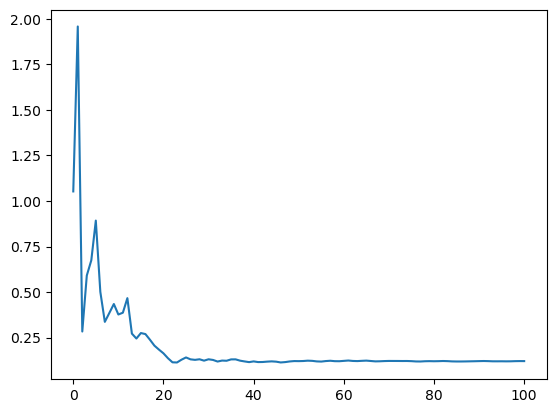

In [16]:
plt.plot(divs)

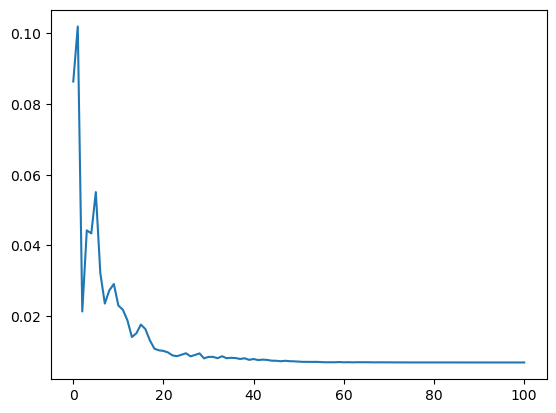

In [17]:
plt.plot(history)

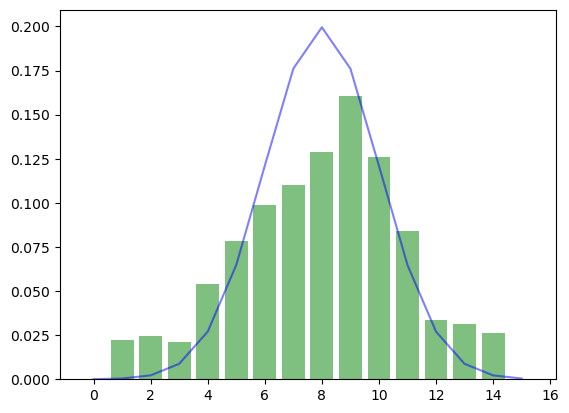

In [18]:
qcbm_probs = circuit(weights)
plt.bar(x,qcbm_probs,color='green',alpha=0.5,label='obtained_distribution')
plt.plot(x,gaussian_distribution,color='blue',alpha=0.5,label='target_distribution')

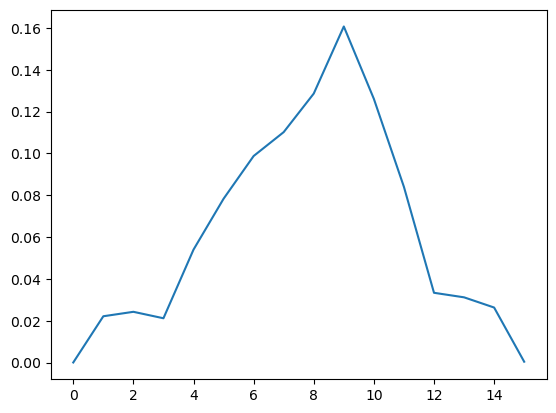

In [19]:
plt.plot(x,qcbm_probs)

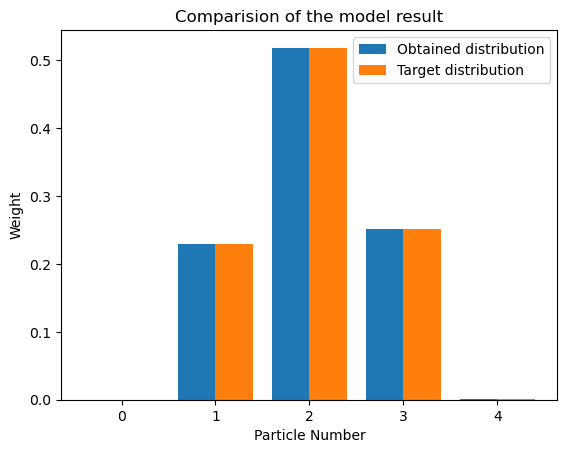

In [20]:
x_axis = np.arange(n_qubits+1)
obtained_pdistribution = pnumber_distribution(qcbm_probs)
plt.bar(x_axis-0.2,obtained_pdistribution,width=0.4,label='Obtained distribution')
plt.bar(x_axis+0.2,targetp_distribution,width=0.4,label='Target distribution')

plt.xticks(x_axis,range(n_qubits+1))
plt.xlabel('Particle Number')
plt.ylabel('Weight')
plt.title('Comparision of the model result')
plt.legend()
plt.show()